<div class="alert alert-block alert-success">

# **1.** Environment Setup

<div>

## 1.1 Connect Google Drive

In [15]:
# from google.colab import drive
# drive.mount('/content/drive')

In [16]:
# import os

# # Change to the directory where project is located
# os.chdir('/content/drive/MyDrive/College/MSc/2nd Semester/Deep Learning/project')

# # Verify that we changed the directory
# print("Changed directory to:", os.getcwd())

## 1.2 Import Libraries

In [17]:
# # # Google Colab
# !pip install keras_cv

In [1]:
import pandas as pd
import zipfile
import pickle
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import regularizers
from classes import *
from functions import *

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import AUC, F1Score, CategoricalAccuracy, TopKCategoricalAccuracy
from keras import optimizers
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
import numpy as np

## 1.3 Import Dataset

The amount of data we have is not supported by GitHub (where we have our project stored). The solution is: create a folder named data and allocate the rare_species file inside it. The gitignore file makes sure this folder is not used when we are pulling or pushing changes but everyone needs to have it on their machines locally. A random seed was used to ensure that the splits stay the same. 

In [3]:
# # Google Colab

# # Define the path to the zip file and the extraction folder
# zip_path = Path("../data/rare_species.zip")

# # Get the directory where the zip file is located
# extract_path = Path("../data/rare_species")

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [4]:
# Import Metadata
metadata_path = Path("../data/rare_species/metadata.csv")
df = pd.read_csv(metadata_path)
df.head()

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...


In [5]:
df.shape # 11983 images

(11983, 7)

<div class="alert alert-block alert-success">

# **2.** Feature Engineering 

<div>

In [6]:
#Load the DataFrames from the .pkl files
with open("../data/train_confident_df_2.pkl", "rb") as f:
     train_df = pickle.load(f)

with open("../data/val_df.pkl", "rb") as f:
     valid_df = pickle.load(f)

with open("../data/test_df.pkl", "rb") as f:
     test_df = pickle.load(f)

In [7]:
minority_class = train_df['family'].value_counts()[train_df['family'].value_counts() < 25].index
minority_class=minority_class.to_list()

In [8]:
batch_size = 32 ## in each epoch the model sees N / batch_size images
image_size = (224, 224)
preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

2025-05-01 02:52:08.535717: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-01 02:52:08.535915: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-01 02:52:08.535924: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-01 02:52:08.536115: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-01 02:52:08.536136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<div class="alert alert-block alert-success">

# **3.** Models

<div>

## EfficientNet (Includes Best Model)

### Set-up

In [9]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

In [10]:
# load datasets
train_ds, class_names = preprocess.load_img(
    data_dir="../data/rare_species/train_confident_2",
    minority_class=minority_class,
    augment='mixup',
    oversampling=True,
    shuffle=True,
    preprocessing_function=preprocess_input)

val_ds, _ = preprocess.load_img(
    data_dir="../data/rare_species/val",
    minority_class=[],
    augment=None,
    shuffle= False,
    preprocessing_function=preprocess_input)

Found 7983 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


### Head Train

In [11]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-4  
final_lr = 4.5409e-05
n_epochs = 25
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
lr_callback = LearningRateScheduler(my_scheduler_fn)

In [12]:
input_img = Input(shape=(224, 224, 3))
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_img)

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(202, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))(x)

model = models.Model(inputs=base_model.input, outputs=x)

model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=metrics
)

In [13]:
callbacks_additional = [lr_callback]

In [14]:
experiment_en = Experiment(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="efficient_net_pre_finetuning_without_outliers_all",
    save_model=False,
    batch_size=32,
    image_size=(224, 224)
)

In [15]:
history_en = experiment_en.run_experiment(callbacks=callbacks_additional, epochs=50)

Epoch 1/50


/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
2025-05-01 02:52:30.849388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


333/333 ━━━━━━━━━━━━━━━━━━━━ 82s 232ms/step - acc: 0.0239 - auc: 0.5734 - f1_score: 0.0122 - loss: 5.3661 - val_acc: 0.2070 - val_auc: 0.8086 - val_f1_score: 0.0753 - val_loss: 4.5634 - learning_rate: 9.6891e-05
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 72s 217ms/step - acc: 0.1560 - auc: 0.7844 - f1_score: 0.0685 - loss: 4.5814 - val_acc: 0.2960 - val_auc: 0.8959 - val_f1_score: 0.1542 - val_loss: 3.9205 - learning_rate: 9.3880e-05
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 80s 239ms/step - acc: 0.2385 - auc: 0.8730 - f1_score: 0.1373 - loss: 4.0177 - val_acc: 0.3545 - val_auc: 0.9319 - val_f1_score: 0.2104 - val_loss: 3.4661 - learning_rate: 9.0961e-05
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 75s 224ms/step - acc: 0.3080 - auc: 0.9088 - f1_score: 0.1987 - loss: 3.5912 - val_acc: 0.4051 - val_auc: 0.9503 - val_f1_score: 0.2697 - val_loss: 3.1257 - learning_rate: 8.8134e-05
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 72s 217ms/step - acc: 0.3571 - auc: 0.9316 - f1_score: 0.2537 - loss: 3.2671 - 

In [16]:
df_history_en = pd.DataFrame(history_en.history)
df_history_en.to_csv('efficient_net_final_without_outliers_all_train_history.csv', index=False)

In [17]:
model.save("efficient_net_pre_finetuning_without_outliers_all.keras")

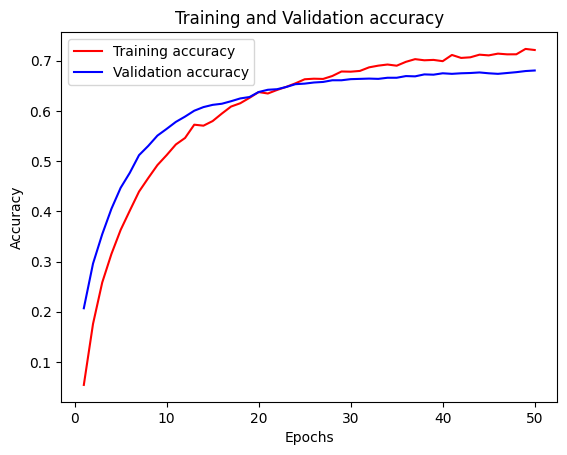

In [18]:
acc_train_en = history_en.history['acc']
acc_val_en = history_en.history['val_acc']
plot_model_acc(num_epochs=50, train_acc=acc_train_en, val_acc=acc_val_en)

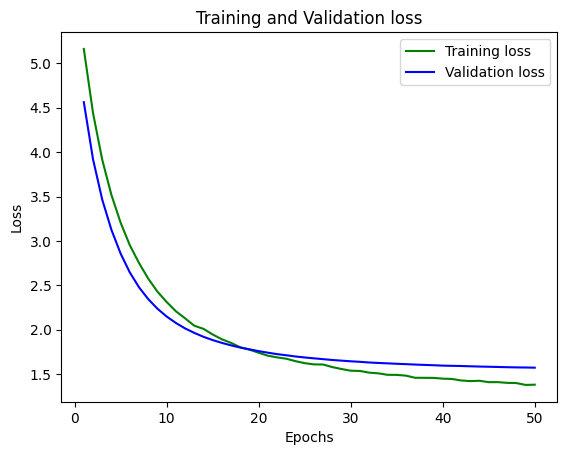

In [19]:
loss_train_en = history_en.history['loss']
loss_val_en = history_en.history['val_loss']
plot_model_loss(num_epochs=50, train_loss=loss_train_en, val_loss=loss_val_en)

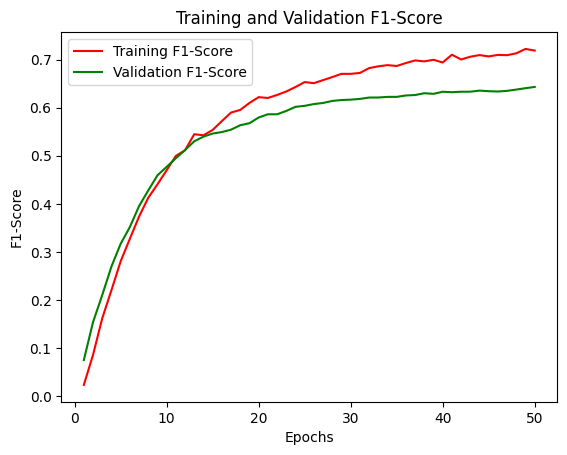

In [20]:
x_axis = range(1,50+1)
plt.plot(x_axis, history_en.history['f1_score'], 'r', label='Training F1-Score')
plt.plot(x_axis, history_en.history['val_f1_score'], 'g', label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

### Fine-tune

References: https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=pt-br

"When fine-tuning a pre-trained model that contains BatchNormalization layers, it is usually a good idea to keep them frozen (i.e., set layer.trainable = False), to avoid corrupting the running statistics that the layers have learned."

In [21]:
base_model_ft_en = load_model("efficient_net_pre_finetuning_without_outliers_all.keras", compile=False)

In [22]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="acc"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

initial_lr = 1e-5
final_lr = 1e-6
n_epochs = 100
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
lr_callback = LearningRateScheduler(my_scheduler_fn)

In [23]:
progressive_unfreeze = ProgressiveUnfreeze(base_model_ft_en) 

base_model_ft_en.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
    metrics=metrics
)


In [26]:
experiment_ft = Experiment(
    model=base_model_ft_en,
    train_ds=train_ds,
    val_ds=val_ds,
    experiment_name="efficientnet_without_outliers_finetune_c",
    save_model=False,
    batch_size=32,
    image_size=(224, 224)
)

history_ft_en = experiment_ft.run_experiment(
    epochs=100,
    callbacks=[progressive_unfreeze, lr_callback]
)

Epoch 1/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - acc: 0.7442 - auc: 0.9914 - f1_score: 0.7163 - loss: 1.3097Epoch 0: Layer now unfrozen 115 (block4c_se_excite)
333/333 ━━━━━━━━━━━━━━━━━━━━ 68s 203ms/step - acc: 0.7442 - auc: 0.9914 - f1_score: 0.7164 - loss: 1.3096 - val_acc: 0.6928 - val_auc: 0.9786 - val_f1_score: 0.6547 - val_loss: 1.5420 - learning_rate: 9.7724e-08
Epoch 2/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 68s 203ms/step - acc: 0.7436 - auc: 0.9917 - f1_score: 0.7126 - loss: 1.3110 - val_acc: 0.6928 - val_auc: 0.9786 - val_f1_score: 0.6547 - val_loss: 1.5420 - learning_rate: 9.5499e-08
Epoch 3/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - acc: 0.7459 - auc: 0.9922 - f1_score: 0.7186 - loss: 1.3069Epoch 2: Layer now unfrozen 114 (block4c_se_expand)
333/333 ━━━━━━━━━━━━━━━━━━━━ 68s 203ms/step - acc: 0.7459 - auc: 0.9922 - f1_score: 0.7187 - loss: 1.3069 - val_acc: 0.6928 - val_auc: 0.9786 - val_f1_score: 0.6547 - val_loss: 1.5420 - learning_rate: 9.3325e-08
Epoch 4/100
333/

In [27]:
df_history_ft_en = pd.DataFrame(history_ft_en.history)
df_history_ft_en.to_csv('efficient_net_final_without_outliers_all_finetune_history.csv', index=False)

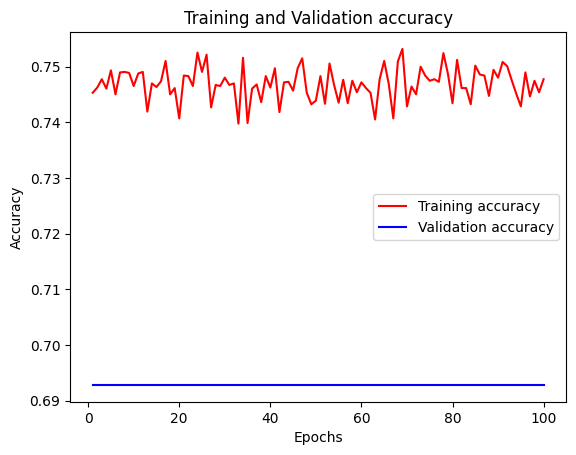

In [29]:
acc_train_ft_en = history_ft_en.history['acc']
acc_val_ft_en = history_ft_en.history['val_acc']
num_epochs = len(acc_train_ft_en)
plot_model_acc(num_epochs=num_epochs, train_acc=acc_train_ft_en, val_acc=acc_val_ft_en)

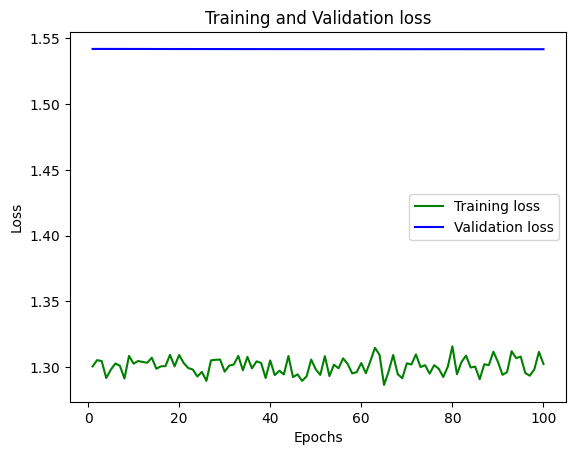

In [30]:
loss_train_ft_en = history_ft_en.history['loss']
loss_val_ft_en = history_ft_en.history['val_loss']
plot_model_loss(num_epochs=num_epochs, train_loss=loss_train_ft_en, val_loss=loss_val_ft_en)

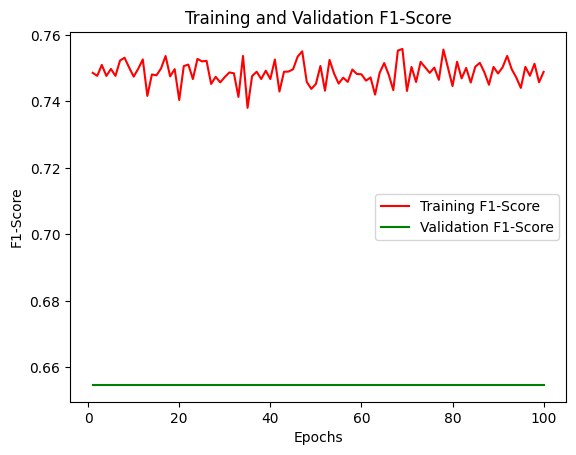

In [32]:
x_axis = range(1,num_epochs+1)
plt.plot(x_axis, history_ft_en.history['f1_score'], 'r', label='Training F1-Score')
plt.plot(x_axis, history_ft_en.history['val_f1_score'], 'g', label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()
plt.show()

In [33]:
base_model_ft_en.save("efficient_net_finetuned_without_outliers_all_final.keras")

### Metrics

In [35]:
get_metric(val_ds, "efficient_net_finetuned_without_outliers_all_final.keras")
get_metric(val_ds,"efficient_net_pre_finetuning_without_outliers_all.keras")
# custom function to include the metrics per class, as well as the precision and recall for error analysis purposes


Evaluating model: efficient_net_finetuned_without_outliers_all_final.keras


/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 96 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-05-01 10:58:28.667425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-

              precision    recall  f1-score   support

           0     0.7391    0.9444    0.8293        18
           1     0.6923    0.6923    0.6923        13
           2     0.6579    0.8065    0.7246        31
           3     0.8000    0.4444    0.5714         9
           4     0.6818    0.8333    0.7500        18
           5     0.7500    0.6000    0.6667         5
           6     0.0000    0.0000    0.0000         4
           7     0.7500    0.6000    0.6667         5
           8     0.0000    0.0000    0.0000         9
           9     0.5000    0.2222    0.3077         9
          10     0.6562    0.7778    0.7119        27
          11     0.6250    0.5556    0.5882         9
          12     1.0000    0.6667    0.8000         9
          13     1.0000    1.0000    1.0000        22
          14     0.6250    0.5556    0.5882         9
          15     1.0000    0.5000    0.6667         4
          16     0.6000    0.6818    0.6383        22
          17     1.0000    

2025-05-01 10:58:45.563820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/brunasimoes/Desktop/nova_ims

(array([  0,   0,   0, ..., 201, 201, 201]),
 array([  0,   0,  25, ..., 201, 201, 201]))